In [1]:
import os
import cv2
import gzip
import shutil
import itertools
import numpy as np
import pandas as pd
import h5py
import resnet50
from IPython.display import SVG
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Using TensorFlow backend.
/home/randomspace/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/randomspace/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/randomspace/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/randomspace/.local/lib/python3.6/site-packag

Default GPU Device: /device:GPU:0


In [2]:
directory = "raw data"
for filename in os.listdir(directory):
    if filename.endswith("gz"):
        filename_unzip = filename.replace(".gz", "")
        if not os.path.exists(os.path.join(directory, filename_unzip)):
            with gzip.open(os.path.join(directory, filename), "rb") as f_in:
                with open(os.path.join(directory, filename_unzip), "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

In [3]:
x_train_h5 = h5py.File(os.path.join(directory, 'camelyonpatch_level_2_split_train_x.h5'), 'r')
x_train = np.array(x_train_h5["x"][:])
y_train_h5 = h5py.File(os.path.join(directory, "camelyonpatch_level_2_split_train_y.h5"), "r")
y_train = np.array(y_train_h5["y"][:])

x_valid_h5 = h5py.File(os.path.join(directory, 'camelyonpatch_level_2_split_valid_x.h5'), 'r')
x_valid = np.array(x_valid_h5["x"][:])
y_valid_h5 = h5py.File(os.path.join(directory, "camelyonpatch_level_2_split_valid_y.h5"), "r")
y_valid = np.array(y_valid_h5["y"][:])

x_test_h5 = h5py.File(os.path.join(directory, 'camelyonpatch_level_2_split_test_x.h5'), 'r')
x_test = np.array(x_test_h5["x"][:])
y_test_h5 = h5py.File(os.path.join(directory, "camelyonpatch_level_2_split_test_y.h5"), "r")
y_test = np.array(y_test_h5["y"][:])

In [4]:
def draw_images(x, y, num_of_rows, num_of_columns):
    f, ax = plt.subplots(nrows = num_of_rows, ncols = num_of_columns,\
                         figsize = (4 * num_of_columns, 4 * num_of_rows))
    
    num_of_images = len(x)
    sample_size = num_of_rows * num_of_columns
    idx = np.random.randint(num_of_images, size = sample_size)
    
    images = x[idx, :]
    labels = y[idx, :]
    
    k = 0
    for i in range(0, num_of_rows):
        for j in range(0, num_of_columns):
            ax[i, j].imshow(images[k])
            ax[i, j].set_title(labels[k, 0, 0, 0], fontsize = 16)
            k += 1
            
    plt.show()

0: no tumor tissue
1: has tumor tissue


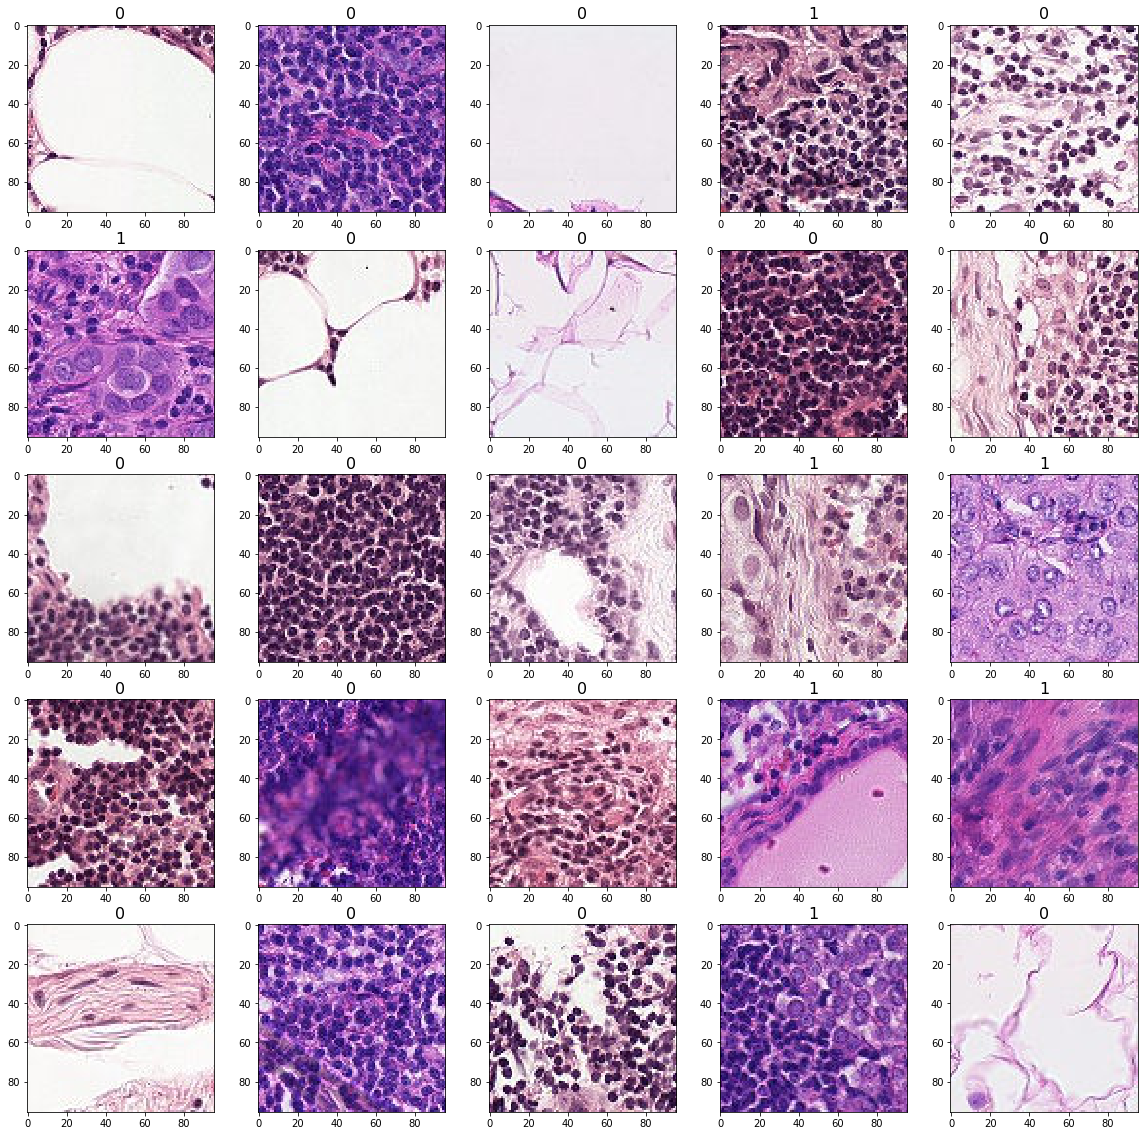

In [5]:
print("0: no tumor tissue")
print("1: has tumor tissue")
draw_images(x_train, y_train, 5, 5)

In [6]:
print(len(x_train))
print(len(x_valid))
print(len(x_test))

262144
32768
32768


In [7]:
base_dir = 'cancer data'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

valid_dir = os.path.join(base_dir, 'valid')
if not os.path.exists(valid_dir):
    os.mkdir(valid_dir)
    
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)

no_tumor_tissue = os.path.join(valid_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(valid_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)
    
no_tumor_tissue = os.path.join(test_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(test_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)

In [8]:
for i in range(len(x_train)):
    label = ""
    target = y_train[i, 0, 0, 0]
    if target == 0:
        label = 'a_no_tumor_tissue'
    elif target == 1:
        label = 'b_has_tumor_tissue'
    if label is not "":
        destination = os.path.join(train_dir, label, "{0}.jpg".format(i))
        cv2.imwrite(destination, x_train[i])

for i in range(len(x_valid)):
    label = ""
    target = y_valid[i, 0, 0, 0]
    if target == 0:
        label = 'a_no_tumor_tissue'
    elif target == 1:
        label = 'b_has_tumor_tissue'
    if label is not "":
        destination = os.path.join(valid_dir, label, "{0}.jpg".format(i))
        cv2.imwrite(destination, x_valid[i])
        
for i in range(len(x_test)):
    label = ""
    target = y_test[i, 0, 0, 0]
    if target == 0:
        label = 'a_no_tumor_tissue'
    elif target == 1:
        label = 'b_has_tumor_tissue'
    if label is not "":
        destination = os.path.join(test_dir, label, "{0}.jpg".format(i))
        cv2.imwrite(destination, x_test[i])

In [9]:
print(len(os.listdir('cancer data/train/a_no_tumor_tissue')))
print(len(os.listdir('cancer data/train/b_has_tumor_tissue')))

131072
131072


In [10]:
print(len(os.listdir('cancer data/valid/a_no_tumor_tissue')))
print(len(os.listdir('cancer data/valid/b_has_tumor_tissue')))

16399
16369


In [11]:
print(len(os.listdir('cancer data/test/a_no_tumor_tissue')))
print(len(os.listdir('cancer data/test/b_has_tumor_tissue')))

16391
16377


In [12]:
IMAGE_SIZE = 64
IMAGE_CHANNELS = 3

train_path = 'cancer data/train'
valid_path = 'cancer data/valid'
test_path = 'cancer data/test'

number_train_samples = len(x_train)
number_valid_samples = len(x_valid)

train_batch_size = 10
valid_batch_size = 10

train_steps = np.ceil(number_train_samples / train_batch_size)
valid_steps = np.ceil(number_valid_samples / valid_batch_size)

print(train_steps)
print(valid_steps)

26215.0
3277.0


In [13]:
datagen = ImageDataGenerator(rescale = 1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size = train_batch_size,
                                        class_mode = 'categorical')

valid_gen = datagen.flow_from_directory(valid_path,
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size = valid_batch_size,
                                        class_mode = 'categorical')

test_gen = datagen.flow_from_directory(test_path,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                       batch_size = 1,
                                       class_mode = 'categorical',
                                       shuffle = False)

Found 262144 images belonging to 2 classes.
Found 32768 images belonging to 2 classes.
Found 32768 images belonging to 2 classes.


In [14]:
model = resnet50.ResNet50(input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS), classes = 2)
model.summary()









__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
ac

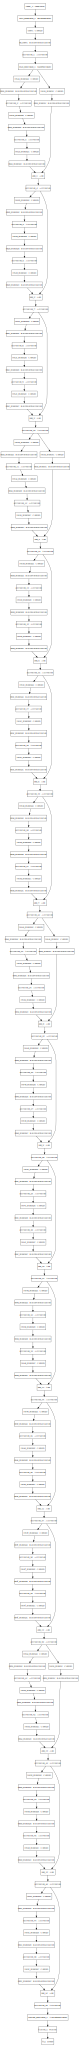

In [15]:
plot_model(model, to_file = 'model.png')
SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

In [16]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_acc',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

In [18]:
history = model.fit_generator(generator = train_gen,
                              steps_per_epoch = train_steps,
                              validation_data = valid_gen,
                              validation_steps = valid_steps,
                              epochs = 20,
                              verbose = 1,
                              callbacks = callbacks_list)

Epoch 1/20
26215/26215 [==============================] - 1741s 66ms/step - loss: 1.0359 - acc: 0.7004 - val_loss: 1.2518 - val_acc: 0.6883

Epoch 00001: val_acc improved from -inf to 0.68832, saving model to model.h5
Epoch 2/20
26215/26215 [==============================] - 1683s 64ms/step - loss: 0.4135 - acc: 0.8170 - val_loss: 0.9699 - val_acc: 0.6018

Epoch 00002: val_acc did not improve from 0.68832
Epoch 3/20
26215/26215 [==============================] - 1724s 66ms/step - loss: 0.3345 - acc: 0.8584 - val_loss: 0.6975 - val_acc: 0.6804

Epoch 00003: val_acc did not improve from 0.68832
Epoch 4/20
26215/26215 [==============================] - 1759s 67ms/step - loss: 0.3000 - acc: 0.8762 - val_loss: 0.4925 - val_acc: 0.7755

Epoch 00004: val_acc improved from 0.68832 to 0.77554, saving model to model.h5
Epoch 5/20
26215/26215 [==============================] - 1721s 66ms/step - loss: 0.2703 - acc: 0.8908 - val_loss: 0.6774 - val_acc: 0.7230

Epoch 00005: val_acc did not improve f

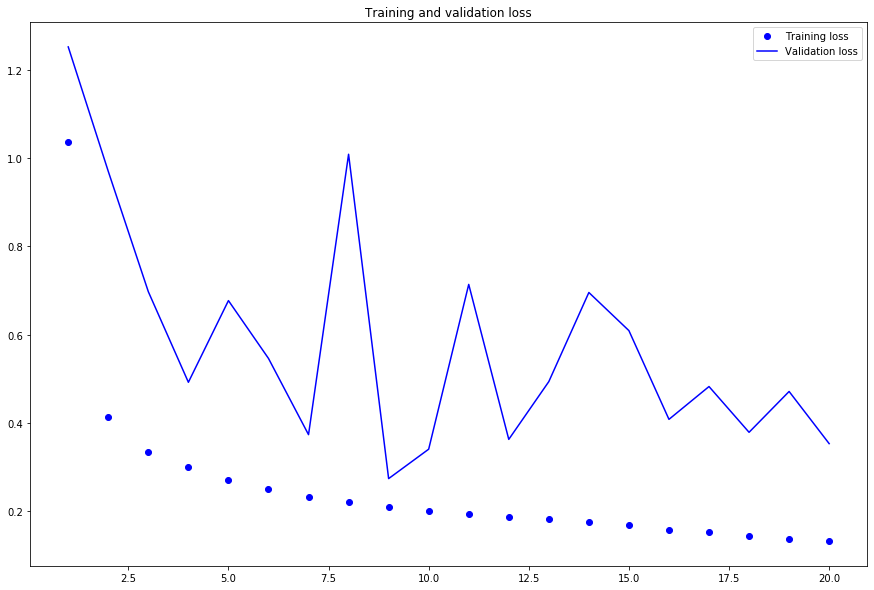

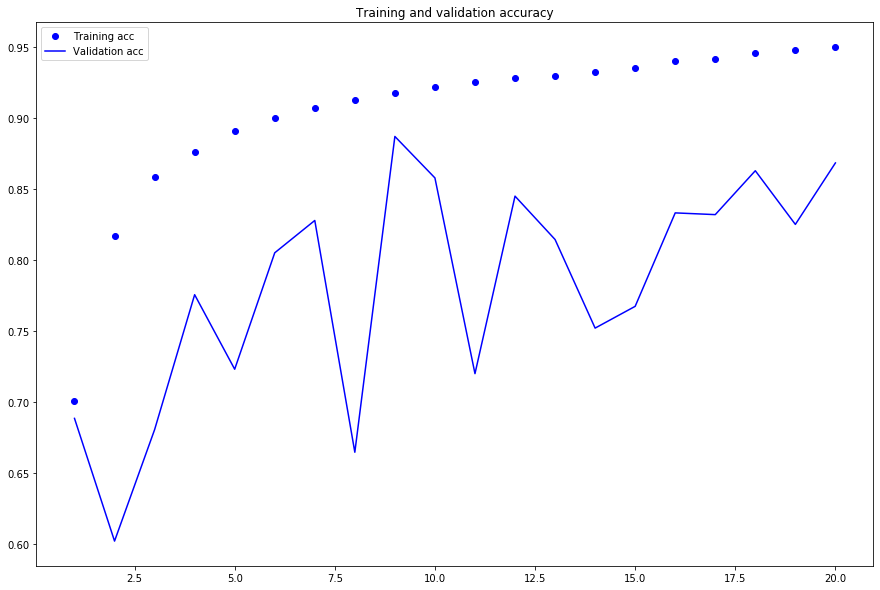

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (15, 10))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure(figsize = (15, 10))
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

In [20]:
model.load_weights(filepath)

In [21]:
predictions = model.predict_generator(test_gen, steps = len(x_test), verbose = 1)

32768/32768 [==============================] - 380s 12ms/step


In [22]:
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [23]:
classes = ['no tumor tissue', 'has tumor tissue']

In [24]:
df_preds = pd.DataFrame(predictions, columns = classes)
df_preds.head()

,no tumor tissue,has tumor tissue
0,0.979361,0.020639
1,0.653983,0.346017
2,0.997101,0.002899
3,0.998389,0.001611
4,0.918049,0.081951


In [25]:
y_true_labels = test_gen.classes
y_predicted_labels = predictions.argmax(axis = 1)
c_report = classification_report(y_true_labels, y_predicted_labels, target_names = classes)
c_matrix = confusion_matrix(y_true_labels, y_predicted_labels)

In [26]:
print(c_report)
print(c_matrix)

                  precision    recall  f1-score   support

 no tumor tissue       0.79      0.88      0.83     16391
has tumor tissue       0.86      0.77      0.82     16377

        accuracy                           0.82     32768
       macro avg       0.83      0.82      0.82     32768
    weighted avg       0.83      0.82      0.82     32768

[[14355  2036]
 [ 3705 12672]]


In [27]:
def plot_confusion_matrix(c_matrix, classes, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.imshow(c_matrix, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = c_matrix.max() / 2
    for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
        plt.text(j, i, format(c_matrix[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if c_matrix[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

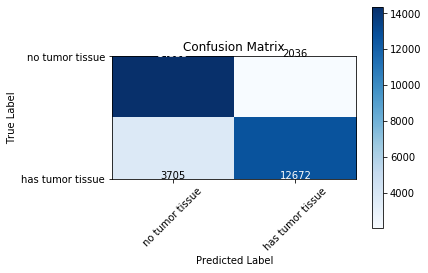

In [28]:
plot_confusion_matrix(c_matrix, classes, title = 'Confusion Matrix')